In [1]:
try:
    sc.stop()
except:
    print('no sc to stop')

In [2]:
# some imports may repeat for modularity inside ipynb

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession 

from pyspark.sql.types import StructField, StringType, IntegerType, StructType
from pyspark.mllib.stat import Statistics 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
conf = SparkConf().setAppName('titanic').setMaster('local[4]')
sc = SparkContext.getOrCreate(conf = conf)

spark = SparkSession.builder.appName('titanic_sql').getOrCreate()
sc

<SparkContext master=local[4] appName=titanic>

In [4]:
spark

In [5]:
data_path = '/home/hadoop/data/train.csv'
df = spark.read.csv("file://{}".format(data_path), inferSchema=True, header=True)

In [6]:
df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

In [7]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [8]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
PassengerId,891,446.0,257.3538420152301,1,891
Survived,891,0.3838383838383838,0.48659245426485753,0,1
Pclass,891,2.308641975308642,0.8360712409770491,1,3
Name,891,None,None,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""","van Melkebeke, Mr. Philemon"
Sex,891,None,None,female,male
Age,714,29.69911764705882,14.526497332334035,0.42,80.0
SibSp,891,0.5230078563411896,1.1027434322934315,0,8
Parch,891,0.38159371492704824,0.8060572211299488,0,6
Ticket,891,260318.54916792738,471609.26868834975,110152,WE/P 5735


In [9]:
df.groupby("Survived").count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  342|
|       0|  549|
+--------+-----+



In [10]:
df.groupby("Sex", "Survived").count().show()

+------+--------+-----+
|   Sex|Survived|count|
+------+--------+-----+
|  male|       0|  468|
|female|       1|  233|
|female|       0|   81|
|  male|       1|  109|
+------+--------+-----+



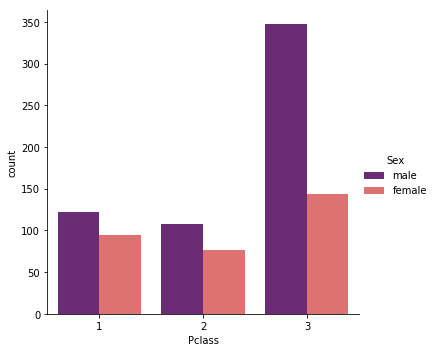

In [11]:
sns.catplot(x='Pclass', kind='count', data=df.toPandas(),
            hue='Sex', palette='magma')

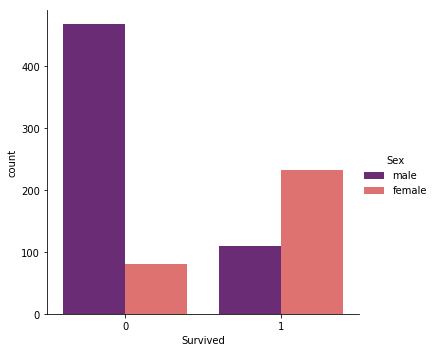

In [12]:
sns.catplot(x='Survived', kind='count', data=df.toPandas(),
            hue='Sex', palette='magma')

In [13]:
from pyspark.sql.functions import count, when, isnan, isnull, mean, regexp_extract, col

In [14]:
#check null vals
def check_null(df):
    return(
        df.select([
            count(
                when(
                    isnull(c), c
                    )
                ).alias(c) 
            for c in df.columns]
        ).show()
    )
check_null(df)

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [15]:
mean_age = df.select(mean('Age')).collect()[0][0]

In [16]:
mean_age

29.69911764705882

In [17]:
ptrn = "([A-Za-z]+)\."


In [18]:
df = df.withColumn("Initial", regexp_extract(col("Name"), ptrn, 1))

In [19]:
titles_lst = [t.Initial for t in df.select('Initial').distinct().collect()]

In [20]:
sorted(titles_lst)

['Capt',
 'Col',
 'Countess',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'Ms',
 'Rev',
 'Sir']

In [21]:
titles_dict={
 'Capt': "Mr",
 'Col': "Mr",
 'Countess': "Mrs",
 'Don': "Mr",
 'Dr': "Mr",
 'Jonkheer': "Mr",
 'Lady': "Mrs",
 'Major': "Mr",
 'Master': "Mr",
 'Miss': "Miss",
 'Mlle': "Miss",
 'Mme': "Mrs",
 'Mr': "Mr",
 'Mrs': "Mrs",
 'Ms': "Miss",
 'Rev': "Mr",
 'Sir': "Mr"}

In [22]:
df = df.replace(['Mlle','Mme','Ms'  ,'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt', 'Sir', 'Don'],
                ['Miss','Mrs','Miss','Mr','Mr'   ,'Mrs' ,'Mrs'     ,'Mr'      ,'Mr' ,'Mr', 'Mr'  , 'Mr' ,'Mr'])


In [23]:
df.groupby("Initial").avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.845637583892618),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=33.02272727272727),
 Row(Initial='Mrs', avg(Age)=35.873873873873876)]

In [24]:
df = df.withColumn("Age", when( (df['Initial']=='Miss')
                 &(df['Age'].isNull()), 22).otherwise(df['Age']))

df = df.withColumn("Age", when( (df['Initial']=='Master')
                 &(df['Age'].isNull()), 5).otherwise(df['Age']))

df = df.withColumn("Age", when( (df['Initial']=='Mr')
                 &(df['Age'].isNull()), 33).otherwise(df['Age']))

df = df.withColumn("Age", when( (df['Initial']=='Mrs')
                 &(df['Age'].isNull()), 36).otherwise(df['Age']))




In [25]:
check_null(df)

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|  687|       2|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+-------+



In [26]:
df = df.drop('Cabin')

In [27]:
df.groupby('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [28]:
df = df.na.fill({"Embarked":'S'})

In [29]:
# Handling string categorical
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

In [30]:
indexers = [StringIndexer(inputCol = column, outputCol = column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]

pipeline = Pipeline(stages=indexers)

df = pipeline.fit(df).transform(df)

In [31]:
df.toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,1.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,1.0,0.0,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,0.0,0.0,0.0
5,6,0,3,"Moran, Mr. James",male,33.0,0,0,330877,8.4583,Q,Mr,0.0,2.0,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,Mr,0.0,0.0,0.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,Master,0.0,0.0,3.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S,Mrs,1.0,0.0,2.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C,Mrs,1.0,1.0,2.0


In [32]:
drop_cols = ["Name", "PassengerId", "Sex", "Ticket", "Embarked", "Initial"]

df = df.drop(*drop_cols)

In [33]:
df

DataFrame[Survived: int, Pclass: int, Age: double, SibSp: int, Parch: int, Fare: double, Sex_index: double, Embarked_index: double, Initial_index: double]

In [34]:
feature = VectorAssembler(inputCols=df.columns[1:], outputCol="features")

feature_vector = feature.transform(df)


In [35]:
### Training data & testing data

In [36]:
trainingData, testData = feature_vector.randomSplit([.8,.2], seed=99)


In [37]:
# Decision tree
from pyspark.ml.classification import DecisionTreeClassifier


In [38]:
dt = DecisionTreeClassifier(labelCol='Survived', featuresCol='features')
dt_model = dt.fit(trainingData)

In [39]:
dt_prediction = dt_model.transform(testData)

In [40]:
dt_prediction.show(5)

+--------+------+----+-----+-----+-------+---------+--------------+-------------+--------------------+-------------+--------------------+----------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Sex_index|Embarked_index|Initial_index|            features|rawPrediction|         probability|prediction|
+--------+------+----+-----+-----+-------+---------+--------------+-------------+--------------------+-------------+--------------------+----------+
|       0|     1|21.0|    0|    1|77.2875|      0.0|           0.0|          0.0|(8,[0,1,3,4],[1.0...| [358.0,68.0]|[0.84037558685446...|       0.0|
|       0|     1|27.0|    0|    2|  211.5|      0.0|           1.0|          0.0|[1.0,27.0,0.0,2.0...| [358.0,68.0]|[0.84037558685446...|       0.0|
|       0|     1|28.0|    0|    0|   47.1|      0.0|           0.0|          0.0|(8,[0,1,4],[1.0,2...| [358.0,68.0]|[0.84037558685446...|       0.0|
|       0|     1|29.0|    1|    0|   66.6|      0.0|           0.0|          0.0|(8,[0,1,2,4],[1.0...| [35

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", 
                                             metricName="accuracy")
# Evaluate on testing data
accuracy = evaluator.evaluate(dt_prediction)
print("Accuracy: ", (accuracy))


Accuracy:  0.8245614035087719


In [42]:
from sklearn.metrics import confusion_matrix

y_true = dt_prediction.select("Survived")
y_true = y_true.toPandas()

y_pred = dt_prediction.select("prediction")
y_pred = y_pred.toPandas()

confusion_mat = confusion_matrix(y_true, y_pred)
confusion_mat


array([[104,   3],
       [ 27,  37]])